# Hearthstone example

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import linprog

import nashpy

In [2]:
def print_payoffs(U, A): 
    '''print_payoffs: Nicely formatted for a 2*2 game 
        INPUTS: 
            U1,U2: (matrices, dim=na1*na2) Payoffs 
            A1: (list of str, len=na1) List of actions of player 1
            A2: (list of str, len=na2) list of actions of player 2
        
        OUTPUT:
            tab: pandas dataframe, na1*na2 with payoff tuples 
    '''
    assert len(U) == 2, f'only implemented for 2-player games'
    assert len(A) == 2, f'only implemented for 2-player games'

    U1 = U[0]
    U2 = U[1]
    A1 = A[0]
    A2 = A[1]

    na1,na2 = U1.shape
    assert len(A1) == na1
    assert len(A2) == na2

    # "matrix" of tuples 
    X = [[(U1[r,c],U2[r,c]) for c in range(na2)] for r in range(na1)]

    # dataframe version 
    tab = pd.DataFrame(X, columns=A2, index=A1)
    
    return tab 

In [3]:
def solve_zerosum_with_linprog(U):
    '''solve_zerosum_with_linprog(): Solve a zero sum game using linear programming
    
        INPUT: U (k*k square matrix), payoffs in zero sum game (opponent gets -U.T)
        OUTPUT: alpha (k-vector) of probability weights for each action (the symmetric equilibrium)
    '''
    k, k2 = U.shape
    assert k == k2, f'Input matrix must be square, got {k}*{k2}'

    oo = np.zeros((1,k))
    ii = np.ones((1,k))

    # objective: c = [-1, 0, 0, ..., 0]
    c = np.insert(oo, 0, -1.0) # insert -1 in front (pos = index 0)
    
    # inequality constraints A*x <= b
    # top = [ 1 ...
    #         1 -1*A.Tl
    #         1  ...  ]
    # bot = [ 0 -1 0 0 
    #         0 0 -1 0 
    #         0 0 0 -1]
    top  = np.hstack( (ii.T, -1*U.T) ) # LHS of v - U <= 0
    bot  = np.hstack( (oo.T, -1*np.eye(k)) ) # LHS of -alpha_k <= 0 for all k 
    A_ub = np.vstack((top, bot))
    
    b_ub = np.zeros((1, 2*k)) # RHS of [v - U <= 0 , -alpha_k <= 0] 
    b_ub = np.matrix(b_ub) 
    
    # contraints Ax = b
    # A = [0, 1, 1, ..., 1]
    A = np.matrix(np.hstack((0, np.ones((k,)))))
    b = 1.0 # just one condition so scalar 

    # v and alpha must be non-negative
    bounds = [(0,None) for i in range(k+1)]

    # call the solver
    sol = linprog(c=c, A_ub=A_ub, b_ub=b_ub, A_eq=A, b_eq=b)
    
    # remove the first element: just return the Nash EQ 
    alpha = sol.x[1:]
    return alpha

# Begin

Payoffs come from the website, TempoStorm, scraped by an anonymous user. 

In [4]:
decks = ["Mid-range Druid", "Token Druid", "Mid-range Hunter",
         "Freeze Mage", "Mech Mage", "Secret Paladin", 
         "Dragon Priest", "Handlock", "Demon Handlock", 
         "Zoolock", "Control Warrior", "Patron Warrior"]

# fake play rates (unable to find historical data)
playrates = np.array([10., 8., 5., 3., 3., 2., 1.3, 1.3, 1.1, 0.9, 0.5, 0.4])
playrates = playrates / playrates.sum()

# winrates for each deck from the tempostorm website
winrates = np.array([
            [50,50,45,75,55,45,40,65,60,35,70,60],
            [50,50,40,60,55,40,35,55,60,40,75,40],
            [55,60,50,35,40,35,40,50,65,45,55,30],
            [25,40,65,50,30,70,70,70,70,80,10,20],
            [45,45,60,70,50,70,40,60,40,30,35,55],
            [55,60,65,30,30,50,50,45,35,55,60,30],
            [60,65,60,30,60,50,50,20,25,70,40,50],
            [35,45,50,30,40,55,80,50,45,65,60,55],
            [40,40,35,30,60,65,75,55,50,60,60,65],
            [65,60,55,20,70,45,30,35,40,50,60,40],
            [30,25,45,90,65,40,60,40,40,40,50,60],
            [40,60,70,80,45,70,50,45,35,60,40,50]]).astype(float)

In [5]:
U1 = winrates 
U2 = -winrates 
U = [U1, U2]
A = [decks, decks]

**Expected utility** Calculated using simple linear algebra: 
\begin{align*}
\mathbb{E}[u^1(a_\ell^1, \alpha^{2})] &= \sum_k=1^K \alpha^{2}_k u^1(a_\ell^1, a_k^2) 
\\ &= U^1 \alpha^2
\end{align*}
To compute the same for Player 2, 
$$ \mathbb{E}[(u^2(\alpha^1, a_\ell^2)] = \alpha^{1\prime} U^2 $$


In [6]:
Eu1 = U1 @ playrates/100.

In [7]:
Eu2 = playrates/100. @ U2 

In [8]:
pd.DataFrame(zip(decks, Eu1, Eu2), columns=['deck', 'Eu1', 'Eu2'])

,deck,Eu1,Eu2
0,Mid-range Druid,0.520000,-0.480000
1,Token Druid,0.492466,-0.507534
2,Mid-range Hunter,0.505068,-0.494932
3,Freeze Mage,0.443562,-0.556438
4,Mech Mage,0.506986,-0.493014
5,Secret Paladin,0.517397,-0.482603
6,Dragon Priest,0.551096,-0.448904
7,Handlock,0.440822,-0.559178
8,Demon Handlock,0.446301,-0.553699
9,Zoolock,0.543699,-0.456301


Playing against the meta vs. playing against a uniform distribution

In [9]:
def Eu(alpha): 
    return winrates @ alpha

In [10]:
uniforms = 1.0/len(decks) * np.ones((len(decks), ))
Eu_uniform = Eu(uniforms)

In [11]:
t = pd.DataFrame(zip(decks,Eu(playrates), Eu(uniforms)), columns=['deck', 'E(u|playrates)', 'E(u|uniform)'])

In [12]:
t

,deck,E(u|playrates),E(u|uniform)
0,Mid-range Druid,52.000000,54.166667
1,Token Druid,49.246575,50.000000
2,Mid-range Hunter,50.506849,46.666667
3,Freeze Mage,44.356164,50.000000
4,Mech Mage,50.698630,50.000000
5,Secret Paladin,51.739726,47.083333
6,Dragon Priest,55.109589,48.333333
7,Handlock,44.082192,50.833333
8,Demon Handlock,44.630137,52.916667
9,Zoolock,54.369863,47.500000


In [13]:
t.max()

deck              Zoolock
E(u|playrates)    55.1096
E(u|uniform)      54.1667
dtype: object

In [14]:
tab = pd.DataFrame(winrates, index=decks, columns=decks)

In [15]:
i = tab.mean(1).sort_values(ascending=False).index.get_level_values(0).values[0]

In [16]:
tab.loc[i].sort_values()

Zoolock             35.0
Dragon Priest       40.0
Mid-range Hunter    45.0
Secret Paladin      45.0
Mid-range Druid     50.0
Token Druid         50.0
Mech Mage           55.0
Demon Handlock      60.0
Patron Warrior      60.0
Handlock            65.0
Control Warrior     70.0
Freeze Mage         75.0
Name: Mid-range Druid, dtype: float64

In [17]:
tab.loc['Zoolock']

Mid-range Druid     65.0
Token Druid         60.0
Mid-range Hunter    55.0
Freeze Mage         20.0
Mech Mage           70.0
Secret Paladin      45.0
Dragon Priest       30.0
Handlock            35.0
Demon Handlock      40.0
Zoolock             50.0
Control Warrior     60.0
Patron Warrior      40.0
Name: Zoolock, dtype: float64

In [18]:
tab = print_payoffs(U, A)
tab

,Mid-range Druid,Token Druid,Mid-range Hunter,Freeze Mage,Mech Mage,Secret Paladin,Dragon Priest,Handlock,Demon Handlock,Zoolock,Control Warrior,Patron Warrior
Mid-range Druid,"(50.0, -50.0)","(50.0, -50.0)","(45.0, -45.0)","(75.0, -75.0)","(55.0, -55.0)","(45.0, -45.0)","(40.0, -40.0)","(65.0, -65.0)","(60.0, -60.0)","(35.0, -35.0)","(70.0, -70.0)","(60.0, -60.0)"
Token Druid,"(50.0, -50.0)","(50.0, -50.0)","(40.0, -40.0)","(60.0, -60.0)","(55.0, -55.0)","(40.0, -40.0)","(35.0, -35.0)","(55.0, -55.0)","(60.0, -60.0)","(40.0, -40.0)","(75.0, -75.0)","(40.0, -40.0)"
Mid-range Hunter,"(55.0, -55.0)","(60.0, -60.0)","(50.0, -50.0)","(35.0, -35.0)","(40.0, -40.0)","(35.0, -35.0)","(40.0, -40.0)","(50.0, -50.0)","(65.0, -65.0)","(45.0, -45.0)","(55.0, -55.0)","(30.0, -30.0)"
Freeze Mage,"(25.0, -25.0)","(40.0, -40.0)","(65.0, -65.0)","(50.0, -50.0)","(30.0, -30.0)","(70.0, -70.0)","(70.0, -70.0)","(70.0, -70.0)","(70.0, -70.0)","(80.0, -80.0)","(10.0, -10.0)","(20.0, -20.0)"
Mech Mage,"(45.0, -45.0)","(45.0, -45.0)","(60.0, -60.0)","(70.0, -70.0)","(50.0, -50.0)","(70.0, -70.0)","(40.0, -40.0)","(60.0, -60.0)","(40.0, -40.0)","(30.0, -30.0)","(35.0, -35.0)","(55.0, -55.0)"
Secret Paladin,"(55.0, -55.0)","(60.0, -60.0)","(65.0, -65.0)","(30.0, -30.0)","(30.0, -30.0)","(50.0, -50.0)","(50.0, -50.0)","(45.0, -45.0)","(35.0, -35.0)","(55.0, -55.0)","(60.0, -60.0)","(30.0, -30.0)"
Dragon Priest,"(60.0, -60.0)","(65.0, -65.0)","(60.0, -60.0)","(30.0, -30.0)","(60.0, -60.0)","(50.0, -50.0)","(50.0, -50.0)","(20.0, -20.0)","(25.0, -25.0)","(70.0, -70.0)","(40.0, -40.0)","(50.0, -50.0)"
Handlock,"(35.0, -35.0)","(45.0, -45.0)","(50.0, -50.0)","(30.0, -30.0)","(40.0, -40.0)","(55.0, -55.0)","(80.0, -80.0)","(50.0, -50.0)","(45.0, -45.0)","(65.0, -65.0)","(60.0, -60.0)","(55.0, -55.0)"
Demon Handlock,"(40.0, -40.0)","(40.0, -40.0)","(35.0, -35.0)","(30.0, -30.0)","(60.0, -60.0)","(65.0, -65.0)","(75.0, -75.0)","(55.0, -55.0)","(50.0, -50.0)","(60.0, -60.0)","(60.0, -60.0)","(65.0, -65.0)"
Zoolock,"(65.0, -65.0)","(60.0, -60.0)","(55.0, -55.0)","(20.0, -20.0)","(70.0, -70.0)","(45.0, -45.0)","(30.0, -30.0)","(35.0, -35.0)","(40.0, -40.0)","(50.0, -50.0)","(60.0, -60.0)","(40.0, -40.0)"


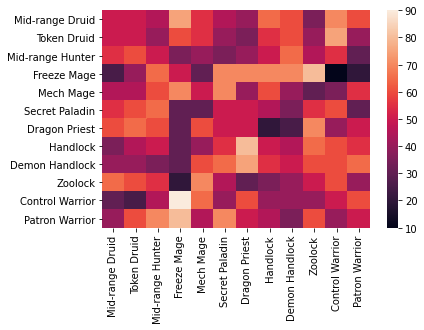

In [19]:
sns.heatmap(U1, xticklabels=decks, yticklabels=decks); 

# Solve with method linear programming

In [20]:
p = solve_zerosum_with_linprog(U1)
p

array([4.00611723e-01, 2.97053135e-08, 1.00917353e-01, 7.33943993e-02,
       1.74365834e-08, 1.52910610e-02, 2.69112722e-01, 6.11624363e-03,
       1.34556676e-01, 2.87107958e-08, 2.02182255e-08, 5.54585233e-08])

In [21]:
sol = pd.DataFrame(zip(decks, p), columns=['deck', 'alpha_NE'])

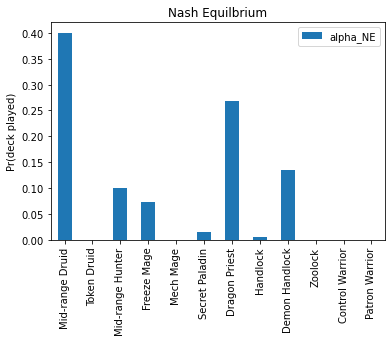

In [22]:
ax = sol.plot(kind='bar')
ax.set_xticklabels(sol.deck); 
ax.set_ylabel('Pr(deck played)'); 
ax.set_title('Nash Equilbrium'); 

# Fictitious play 

In [23]:
G = nashpy.Game(U[0], U[1])

In [24]:
nit = 1000
f = np.array(list(G.fictitious_play(nit))) / nit

In [25]:
i_player = 0
history = f[:, i_player, :] 

In [26]:
i_deck = U1.mean(1).argmax()

In [27]:
i_deck = 9

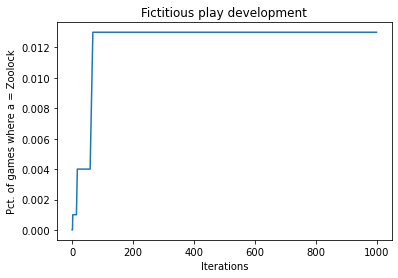

In [28]:
plt.plot(history[:, i_deck]); 
plt.title(f'Fictitious play development');
plt.xlabel('Iterations'); 
plt.ylabel(f'Pct. of games where a = {A[0][i_deck]}'); 

In [29]:
fp = pd.DataFrame(zip(A[0], np.array(history[-1, :])), columns=['deck', 'alpha_fict_play'])

In [30]:
res = pd.merge(sol, fp, on='deck', how='left')

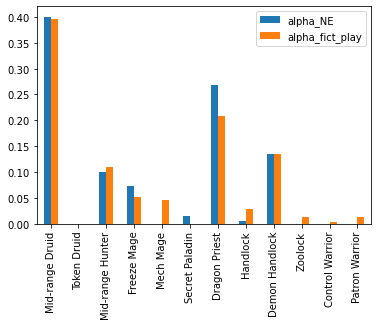

In [31]:
ax = res.plot.bar(); 
ax.set_xticklabels(res.deck); 

# Lemke-Howson 

This algorithm behaves rather badly on this game, which illustrates the power of the linear programming algorithm. 

In [32]:
G = nashpy.Game(U1, U2)

In [33]:
s = G.lemke_howson_enumeration()

In [34]:
sol = next(s)

/Users/mrz577/opt/anaconda3/lib/python3.8/site-packages/nashpy/integer_pivoting/integer_pivoting.py:54: RuntimeWarning: overflow encountered in multiply
  tableau[i, :] * pivot_element
/Users/mrz577/opt/anaconda3/lib/python3.8/site-packages/nashpy/integer_pivoting/integer_pivoting.py:55: RuntimeWarning: overflow encountered in multiply
  - tableau[pivot_row_index, :] * tableau[i, column_index]
/Users/mrz577/opt/anaconda3/lib/python3.8/site-packages/nashpy/integer_pivoting/integer_pivoting.py:54: RuntimeWarning: invalid value encountered in subtract
  tableau[i, :] * pivot_element
/Users/mrz577/opt/anaconda3/lib/python3.8/site-packages/nashpy/integer_pivoting/integer_pivoting.py:31: RuntimeWarning: invalid value encountered in true_divide
  return np.argmax(tableau[:, column_index] / tableau[:, -1])
/Users/mrz577/opt/anaconda3/lib/python3.8/site-packages/nashpy/integer_pivoting/integer_pivoting.py:54: RuntimeWarning: invalid value encountered in multiply
  tableau[i, :] * pivot_element


In [35]:
sol

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan]))

# Simple support enumeration

This one is even worse than Lemke-Hawson and sometimes does not even finish. 

In [36]:
s = G.support_enumeration()

In [ ]:
sol0 = next(s)